## Data Prep

**Import necessary modules and the ASOS/SNOTEL dataframes**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dtb
import os
from glob import glob
import datetime as dt
import seaborn as sns

In [2]:
data = [pd.read_csv('asos_snotel_UA_12hr_df.dat', parse_dates = True, index_col = 'Date_Time')]
asos_snotel_UA_df = pd.concat(data)
#asos_snotel_UA_df['LXV_WindSpeed_m/s']

#asos_snotel_UA_df.rename(columns={'LXV_WindSpeed_m/s': 'LXV_WindSpeed_mps'}, inplace=True)

asos_snotel_UA_df.astype('float16')
pd.set_option('display.expand_frame_repr', True)


print(asos_snotel_UA_df.keys())

print(asos_snotel_UA_df.info())


#delete empty columns as they mess up loops
#del asos_snotel_UA_df['CMtn_6hr_Precipitation_mm']            #empty column
print(asos_snotel_UA_df.describe())

Index(['CMtnSNTL_Temp_degC', 'CMtnSNTL_SnowDepth_in', 'CMtn_Temperature_degC',
       'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps',
       'CMtn_CloudCover_oktas', 'CMtn_1hr_Precipitation_mm',
       'LXV_Temperature_degC', 'LXV_Dewpoint_degC',
       ...
       'KGJT_d300_200_height_m', 'KGJT_d300_200_tmpc', 'KGJT_d300_200_dwpc',
       'KGJT_d300_200_drct', 'KGJT_d300_200_speed_kts',
       'KGJT_d250_200_height_m', 'KGJT_d250_200_tmpc', 'KGJT_d250_200_dwpc',
       'KGJT_d250_200_drct', 'KGJT_d250_200_speed_kts'],
      dtype='object', length=163)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9294 entries, 2005-04-12 00:00:00+00:00 to 2017-12-31 12:00:00+00:00
Columns: 163 entries, CMtnSNTL_Temp_degC to KGJT_d250_200_speed_kts
dtypes: float64(163)
memory usage: 11.6 MB
None
       CMtnSNTL_Temp_degC  CMtnSNTL_SnowDepth_in  CMtn_Temperature_degC  \
count         8710.000000            8695.000000            7362.000000   
mean            -0.001883      

In [3]:
all_yrs = (asos_snotel_UA_df.index >= '01-01-2006') & (asos_snotel_UA_df.index < '01-01-2018')
test_yrs = (asos_snotel_UA_df.index >= '01-01-2015')
train_yrs = (asos_snotel_UA_df.index >= '01-01-2006') & (asos_snotel_UA_df.index < '01-01-2015')
print(len(train_yrs ))

9294


It is important to keep in mind that 'CMtnSNTL_12hr_SNWD_in contains snow depth info taken at the start of the respective 12hr period timestamp.  The snowfall calculated also gives the snowfall that fell in the 12hrs after the timestamp.  The OLS model will utilize hourly meteorological measurements at exactly 00:00 and 12:00 hours to predict the amount of snow which will fall in the next 12 hour period.  For example, the 00:00 meteorological measurements will be used to predict the snow which fell between 00:00 and 12:00.

***
# OLS Analysis of meteorological variables and snowfall (Training Dataset: 2007-2016 only)

**We will first utilize just the Copper Mountain surface level variables and run the model explicitly to generate statistics.  This will give snowfall predictive capability of individual meteorological variables (Dewpoint, SNOTEL Temperature, Temperature, Wind Speed, Cloud Cover, Wind Direction, 6hr Pressure change, and Pressure) using an OLS model and the 2008-2017 training dataset. The resulting values will also be used to verify some code which performs same analysis, but with a loop.  This code will then be fed all upper air and surface level variables to determine best combination of variables in the OLS model.**


In [4]:
#Import statsmodel

import statsmodels.api as sm
#import statsmodel
from statsmodels.formula.api import ols

#### Single Variable Summary
**Adjusted R:**  
OLS_CMtn_Dewpoint: 0.007  
OLS_CMtnSNTL_Temp:  -0.002 
OLS_CMtn_Temperature: -0.005  
OLS_CMtn_WindSpeed:  0.017  
OLS_CMtn_CloudCover:  0.000  
OLS_CMtn_WindDirection:  -0.004  
OLS_LXV_6hr_delta_Pressure:   0.004  
OLS_LXV_Pressure:    -0.003  

**Prob (F-statistic):**  
OLS_CMtn_Dewpoint: 0.139  
OLS_CMtnSNTL_Temp: 0.483  
OLS_CMtn_Temperature:  0.708  
OLS_CMtn_WindSpeed:  0.0466  
OLS_CMtn_CloudCover: 0.316 
OLS_CMtn_WindDirection:   0.614  
OLS_LXV_6hr_delta_Pressure:  0.155  
OLS_LXV_Pressure:   0.550 
  
From this, we can glean that Dewpoint alone likely has the best fit as the adjusted R squared is the highest.  The F statistics such signficant correlations (at 5% confident interval) for only  Dewpoint and Pressure).

## Determine which columns to use in OLS model.   
### Only going to to keep those data columns which have a matching hour to at least 67% of the snowfall measurements

In [5]:
variables = ['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'CMtn_CloudCover_oktas', \
 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_CloudCover_oktas', 'LXV_12hr_delta_Pressure_hp', \
 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', \
 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', \
 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', \
 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', \
 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', \
 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', \
 'KGJT_850mb_height_m', 'KGJT_850mb_tmpc', 'KGJT_850mb_dwpc', 'KGJT_850mb_drct', 'KGJT_850mb_speed_kts', \
 'KGJT_d850_700_height_m', 'KGJT_d850_700_tmpc', 'KGJT_d850_700_dwpc', 'KGJT_d850_700_drct', 'KGJT_d850_700_speed_kts', \
 'KGJT_d850_500_height_m', 'KGJT_d850_500_tmpc', 'KGJT_d850_500_dwpc', 'KGJT_d850_500_drct', 'KGJT_d850_500_speed_kts', \
 'KGJT_d850_400_height_m', 'KGJT_d850_400_tmpc', 'KGJT_d850_400_dwpc', 'KGJT_d850_400_drct', 'KGJT_d850_400_speed_kts', \
 'KGJT_d850_300_height_m', 'KGJT_d850_300_tmpc', 'KGJT_d850_300_dwpc', 'KGJT_d850_300_drct', 'KGJT_d850_300_speed_kts', \
 'KGJT_d850_250_height_m', 'KGJT_d850_250_tmpc', 'KGJT_d850_250_dwpc', 'KGJT_d850_250_drct', 'KGJT_d850_250_speed_kts', \
 'KGJT_d850_200_height_m', 'KGJT_d850_200_tmpc', 'KGJT_d850_200_dwpc', 'KGJT_d850_200_drct', 'KGJT_d850_200_speed_kts',\
 'KGJT_d700_500_height_m', 'KGJT_d700_500_tmpc', 'KGJT_d700_500_dwpc', 'KGJT_d700_500_drct', 'KGJT_d700_500_speed_kts', \
 'KGJT_d700_400_height_m', 'KGJT_d700_400_tmpc', 'KGJT_d700_400_dwpc', 'KGJT_d700_400_drct', 'KGJT_d700_400_speed_kts', \
 'KGJT_d700_300_height_m', 'KGJT_d700_300_tmpc', 'KGJT_d700_300_dwpc', 'KGJT_d700_300_drct', 'KGJT_d700_300_speed_kts', \
 'KGJT_d700_250_height_m', 'KGJT_d700_250_tmpc', 'KGJT_d700_250_dwpc', 'KGJT_d700_250_drct', 'KGJT_d700_250_speed_kts', \
 'KGJT_d700_200_height_m', 'KGJT_d700_200_tmpc', 'KGJT_d700_200_dwpc', 'KGJT_d700_200_drct', 'KGJT_d700_200_speed_kts', \
 'KGJT_d500_400_height_m', 'KGJT_d500_400_tmpc', 'KGJT_d500_400_dwpc', 'KGJT_d500_400_drct', 'KGJT_d500_400_speed_kts', \
 'KGJT_d500_300_height_m', 'KGJT_d500_300_tmpc', 'KGJT_d500_300_dwpc', 'KGJT_d500_300_drct', 'KGJT_d500_300_speed_kts', \
 'KGJT_d500_250_height_m', 'KGJT_d500_250_tmpc', 'KGJT_d500_250_dwpc', 'KGJT_d500_250_drct', 'KGJT_d500_250_speed_kts', \
 'KGJT_d500_200_height_m', 'KGJT_d500_200_tmpc', 'KGJT_d500_200_dwpc', 'KGJT_d500_200_drct', 'KGJT_d500_200_speed_kts', \
 'KGJT_d400_300_height_m', 'KGJT_d400_300_tmpc', 'KGJT_d400_300_dwpc', 'KGJT_d400_300_drct', 'KGJT_d400_300_speed_kts', \
 'KGJT_d400_250_height_m', 'KGJT_d400_250_tmpc', 'KGJT_d400_250_dwpc', 'KGJT_d400_250_drct', 'KGJT_d400_250_speed_kts', \
 'KGJT_d400_200_height_m', 'KGJT_d400_200_tmpc', 'KGJT_d400_200_dwpc', 'KGJT_d400_200_drct', 'KGJT_d400_200_speed_kts', \
 'KGJT_d300_250_height_m', 'KGJT_d300_250_tmpc', 'KGJT_d300_250_dwpc', 'KGJT_d300_250_drct', 'KGJT_d300_250_speed_kts', \
 'KGJT_d300_200_height_m', 'KGJT_d300_200_tmpc', 'KGJT_d300_200_dwpc', 'KGJT_d300_200_drct', 'KGJT_d300_200_speed_kts', \
 'KGJT_d250_200_height_m', 'KGJT_d250_200_tmpc', 'KGJT_d250_200_dwpc', 'KGJT_d250_200_drct', 'KGJT_d250_200_speed_kts']


good_vars = []
bad_vars = []
for var in variables:
    idx = np.isfinite(asos_snotel_UA_df[all_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']) & np.isfinite(asos_snotel_UA_df[all_yrs][var])
 #   total_poss = len(asos_snotel_UA_df[all_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][asos_snotel_UA_df[all_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']>=0])
    
    total_poss = asos_snotel_UA_df[all_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'].count()   #counts only non missing values
    total_avail =len(asos_snotel_UA_df[all_yrs][idx]) 
    
    if total_avail/total_poss >= 0.67: 
        good_vars.append(var)
    else:
        bad_vars.append(var)
        
print('Variables with >= 67% data match to snowfall: ')
print(good_vars)
print('Variables with < 67% data match to snowfall: ')
print(bad_vars)
    

print(asos_snotel_UA_df.describe())


Variables with >= 67% data match to snowfall: 
['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp', 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', 'KGJT_850mb_height_m', 'KGJT_d850_700_height_m', 'KGJT_d850_500_height_

In [6]:
good_vars_snf =[]
filtered_asos_snotel_UA_df = pd.DataFrame()


good_vars_snf = good_vars + ['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']
print(good_vars_snf )
filtered_asos_snotel_UA_df=  asos_snotel_UA_df[good_vars_snf].copy()
test_train_df = asos_snotel_UA_df[good_vars_snf].dropna()
#test_df = asos_snotel_UA_df[good_vars_snf][test_yrs].dropna()
#train_df = asos_snotel_UA_df[good_vars_snf][train_yrs].dropna()

#print(test_df.describe())
#print(train_df.describe())
#print(filtered_asos_snotel_UA_df[train_yrs].dropna().describe())
print(asos_snotel_UA_df[good_vars_snf].dropna().describe())

['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp', 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', 'KGJT_850mb_height_m', 'KGJT_d850_700_height_m', 'KGJT_d850_500_height_m', 'KGJT_d850_400_height_m', 'KGJT_d850_300_he

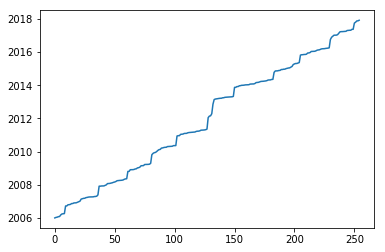

In [7]:
import statistics as sts
all_yrs_tt = (test_train_df.index >= '01-01-2006') & (test_train_df.index < '01-01-2018')
test_yrs_tt=  (test_train_df.index >= '01-01-2015')
train_yrs_tt = (test_train_df.index >= '01-01-2006') & (test_train_df.index < '01-01-2015')

plt.plot(test_train_df.index)

### Now run OLS model with the chosen variables ##

In [8]:
from collections import OrderedDict

variables = good_vars
variables_org = variables
print(variables)

print('******')
adjRs = []
newRs = []
dup_var = []
max_vars = []
f_pvalues = []

while variables != []:
  #print(variables)
  for var in variables:
        
    #print(variables)
    max_var = max(variables, key = lambda v: ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + v, test_train_df[train_yrs_tt]).fit().rsquared_adj)    #this finds OLS model run with highest adj R squared
    OLS = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + max_var, test_train_df[train_yrs_tt]).fit()
    print(max_var)
    print(OLS.rsquared_adj)
    
    #Create lists of statistics for each combination of variables modeld
    adjRs.append(OLS.rsquared_adj)
    f_pvalues.append(OLS.f_pvalue)
    max_vars.append(max_var)

    add_max_var = '+ '+ max_var
    
    variables = [s + add_max_var for s in variables_org]
    
    #The above for loop naturally will create a duplicate variable, which should be removed
    for v in variables_org: 
      dup_var = []
      dup_var = [var for var in variables if var.count(v)>1]
      if dup_var!=[]:
            for dup in dup_var: variables.remove(dup)

#combine the modeled variable sequences with respective stats  
stats = list(zip(adjRs, f_pvalues))    # create list of tuples
dictionary = OrderedDict(zip(max_vars, stats))
#dictionary_adjRs = OrderedDict(zip(max_vars, f_pvalues))
print(adjRs)
print(max_vars)
print(f_pvalues)
print(dictionary)



['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp', 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', 'KGJT_850mb_height_m', 'KGJT_d850_700_height_m', 'KGJT_d850_500_height_m', 'KGJT_d850_400_height_m', 'KGJT_d850_300_he

KGJT_d700_500_tmpc+ KGJT_d700_250_tmpc+ KGJT_d500_200_speed_kts+ KGJT_d700_300_drct+ KGJT_500mb_height_m+ LXV_Pressure_hp+ KGJT_500mb_dwpc+ KGJT_200mb_tmpc+ KGJT_d250_200_speed_kts+ KGJT_700mb_tmpc+ CMtn_WindDirection_deg+ KGJT_d700_400_height_m+ LXV_Dewpoint_degC+ CMtn_Dewpoint_degC+ KGJT_d500_250_speed_kts+ KGJT_d500_300_dwpc+ KGJT_d700_500_drct+ KGJT_d300_250_drct+ KGJT_250mb_tmpc+ KGJT_700mb_speed_kts+ KGJT_d250_200_dwpc+ KGJT_d500_200_tmpc+ KGJT_d500_400_height_m
0.18142517612504538
KGJT_d500_250_drct+ KGJT_d700_500_tmpc+ KGJT_d700_250_tmpc+ KGJT_d500_200_speed_kts+ KGJT_d700_300_drct+ KGJT_500mb_height_m+ LXV_Pressure_hp+ KGJT_500mb_dwpc+ KGJT_200mb_tmpc+ KGJT_d250_200_speed_kts+ KGJT_700mb_tmpc+ CMtn_WindDirection_deg+ KGJT_d700_400_height_m+ LXV_Dewpoint_degC+ CMtn_Dewpoint_degC+ KGJT_d500_250_speed_kts+ KGJT_d500_300_dwpc+ KGJT_d700_500_drct+ KGJT_d300_250_drct+ KGJT_250mb_tmpc+ KGJT_700mb_speed_kts+ KGJT_d250_200_dwpc+ KGJT_d500_200_tmpc+ KGJT_d500_400_height_m
0.181425176125

KGJT_500mb_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_300mb_dwpc+ KGJT_d250_200_tmpc+ KGJT_d700_200_tmpc+ KGJT_d700_500_height_m+ KGJT_400mb_height_m+ KGJT_700mb_height_m+ KGJT_d700_250_drct+ KGJT_d500_250_tmpc+ KGJT_d500_300_drct+ KGJT_500mb_tmpc+ KGJT_d500_250_drct+ KGJT_d700_500_tmpc+ KGJT_d700_250_tmpc+ KGJT_d500_200_speed_kts+ KGJT_d700_300_drct+ KGJT_500mb_height_m+ LXV_Pressure_hp+ KGJT_500mb_dwpc+ KGJT_200mb_tmpc+ KGJT_d250_200_speed_kts+ KGJT_700mb_tmpc+ CMtn_WindDirection_deg+ KGJT_d700_400_height_m+ LXV_Dewpoint_degC+ CMtn_Dewpoint_degC+ KGJT_d500_250_speed_kts+ KGJT_d500_300_dwpc+ KGJT_d700_500_drct+ KGJT_d300_250_drct+ KGJT_250mb_tmpc+ KGJT_700mb_speed_kts+ KGJT_d250_200_dwpc+ KGJT_d500_200_tmpc+ KGJT_d500_400_height_m
0.17820474123983132
KGJT_d700_200_speed_kts+ KGJT_500mb_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_300mb_dwpc+ KGJT_d250_200_tmpc+ KGJT_d700_200_tmpc+ KGJT_d700_500_height_m+ KGJT_400mb_height_m+ KGJT_700mb_heigh

KGJT_d400_200_dwpc+ KGJT_d250_200_height_m+ KGJT_d400_250_tmpc+ KGJT_d400_200_tmpc+ KGJT_d700_400_tmpc+ KGJT_400mb_tmpc+ KGJT_d500_400_tmpc+ KGJT_250mb_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d700_200_speed_kts+ KGJT_500mb_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_300mb_dwpc+ KGJT_d250_200_tmpc+ KGJT_d700_200_tmpc+ KGJT_d700_500_height_m+ KGJT_400mb_height_m+ KGJT_700mb_height_m+ KGJT_d700_250_drct+ KGJT_d500_250_tmpc+ KGJT_d500_300_drct+ KGJT_500mb_tmpc+ KGJT_d500_250_drct+ KGJT_d700_500_tmpc+ KGJT_d700_250_tmpc+ KGJT_d500_200_speed_kts+ KGJT_d700_300_drct+ KGJT_500mb_height_m+ LXV_Pressure_hp+ KGJT_500mb_dwpc+ KGJT_200mb_tmpc+ KGJT_d250_200_speed_kts+ KGJT_700mb_tmpc+ CMtn_WindDirection_deg+ KGJT_d700_400_height_m+ LXV_Dewpoint_degC+ CMtn_Dewpoint_degC+ KGJT_d500_250_speed_kts+ KGJT_d500_300_dwpc+ KGJT_d700_500_drct+ KGJT_d300_250_drct+ KGJT_250mb_tmpc+ KGJT_700mb_speed_kts+ KGJT_d250_200_dwpc+ KGJT_d500_200_tmpc+ KGJT_d500_400_height_m
0.16801712500806387
KGJT_

KGJT_d400_250_drct+ KGJT_d700_400_drct+ KGJT_d400_300_drct+ LXV_WindSpeed_mps+ KGJT_200mb_drct+ LXV_12hr_delta_Pressure_hp+ KGJT_d400_300_speed_kts+ KGJT_d400_250_dwpc+ KGJT_d400_200_dwpc+ KGJT_d250_200_height_m+ KGJT_d400_250_tmpc+ KGJT_d400_200_tmpc+ KGJT_d700_400_tmpc+ KGJT_400mb_tmpc+ KGJT_d500_400_tmpc+ KGJT_250mb_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d700_200_speed_kts+ KGJT_500mb_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_300mb_dwpc+ KGJT_d250_200_tmpc+ KGJT_d700_200_tmpc+ KGJT_d700_500_height_m+ KGJT_400mb_height_m+ KGJT_700mb_height_m+ KGJT_d700_250_drct+ KGJT_d500_250_tmpc+ KGJT_d500_300_drct+ KGJT_500mb_tmpc+ KGJT_d500_250_drct+ KGJT_d700_500_tmpc+ KGJT_d700_250_tmpc+ KGJT_d500_200_speed_kts+ KGJT_d700_300_drct+ KGJT_500mb_height_m+ LXV_Pressure_hp+ KGJT_500mb_dwpc+ KGJT_200mb_tmpc+ KGJT_d250_200_speed_kts+ KGJT_700mb_tmpc+ CMtn_WindDirection_deg+ KGJT_d700_400_height_m+ LXV_Dewpoint_degC+ CMtn_Dewpoint_degC+ KGJT_d500_250_speed_kts+ KGJT_d500_300_dwpc

KGJT_d500_300_tmpc+ KGJT_d300_250_tmpc+ KGJT_d400_300_height_m+ KGJT_d500_300_height_m+ KGJT_d700_300_height_m+ KGJT_300mb_height_m+ KGJT_d500_400_drct+ KGJT_d400_250_drct+ KGJT_d700_400_drct+ KGJT_d400_300_drct+ LXV_WindSpeed_mps+ KGJT_200mb_drct+ LXV_12hr_delta_Pressure_hp+ KGJT_d400_300_speed_kts+ KGJT_d400_250_dwpc+ KGJT_d400_200_dwpc+ KGJT_d250_200_height_m+ KGJT_d400_250_tmpc+ KGJT_d400_200_tmpc+ KGJT_d700_400_tmpc+ KGJT_400mb_tmpc+ KGJT_d500_400_tmpc+ KGJT_250mb_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d700_200_speed_kts+ KGJT_500mb_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_300mb_dwpc+ KGJT_d250_200_tmpc+ KGJT_d700_200_tmpc+ KGJT_d700_500_height_m+ KGJT_400mb_height_m+ KGJT_700mb_height_m+ KGJT_d700_250_drct+ KGJT_d500_250_tmpc+ KGJT_d500_300_drct+ KGJT_500mb_tmpc+ KGJT_d500_250_drct+ KGJT_d700_500_tmpc+ KGJT_d700_250_tmpc+ KGJT_d500_200_speed_kts+ KGJT_d700_300_drct+ KGJT_500mb_height_m+ LXV_Pressure_hp+ KGJT_500mb_dwpc+ KGJT_200mb_tmpc+ KGJT_d250_200_speed

KGJT_d300_200_height_m+ KGJT_d300_250_height_m+ KGJT_200mb_height_m+ KGJT_d300_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_d700_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d500_300_tmpc+ KGJT_d300_250_tmpc+ KGJT_d400_300_height_m+ KGJT_d500_300_height_m+ KGJT_d700_300_height_m+ KGJT_300mb_height_m+ KGJT_d500_400_drct+ KGJT_d400_250_drct+ KGJT_d700_400_drct+ KGJT_d400_300_drct+ LXV_WindSpeed_mps+ KGJT_200mb_drct+ LXV_12hr_delta_Pressure_hp+ KGJT_d400_300_speed_kts+ KGJT_d400_250_dwpc+ KGJT_d400_200_dwpc+ KGJT_d250_200_height_m+ KGJT_d400_250_tmpc+ KGJT_d400_200_tmpc+ KGJT_d700_400_tmpc+ KGJT_400mb_tmpc+ KGJT_d500_400_tmpc+ KGJT_250mb_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d700_200_speed_kts+ KGJT_500mb_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_300mb_dwpc+ KGJT_d250_200_tmpc+ KGJT_d700_200_tmpc+ KGJT_d700_500_height_m+ KGJT_400mb_height_m+ KGJT_700mb_height_m+ KGJT_d700_250_drct+ KGJT_d500_250_tmpc+ KGJT_d500_300_drct+ KGJT_500mb_tmpc+ KGJT_d500_250_drct+ KGJT_d700_500_tmpc+ KGJT_d700_

KGJT_d400_250_height_m+ KGJT_d700_200_height_m+ KGJT_d500_250_height_m+ KGJT_d400_200_height_m+ KGJT_250mb_height_m+ KGJT_d700_250_height_m+ KGJT_d300_200_height_m+ KGJT_d300_250_height_m+ KGJT_200mb_height_m+ KGJT_d300_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_d700_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d500_300_tmpc+ KGJT_d300_250_tmpc+ KGJT_d400_300_height_m+ KGJT_d500_300_height_m+ KGJT_d700_300_height_m+ KGJT_300mb_height_m+ KGJT_d500_400_drct+ KGJT_d400_250_drct+ KGJT_d700_400_drct+ KGJT_d400_300_drct+ LXV_WindSpeed_mps+ KGJT_200mb_drct+ LXV_12hr_delta_Pressure_hp+ KGJT_d400_300_speed_kts+ KGJT_d400_250_dwpc+ KGJT_d400_200_dwpc+ KGJT_d250_200_height_m+ KGJT_d400_250_tmpc+ KGJT_d400_200_tmpc+ KGJT_d700_400_tmpc+ KGJT_400mb_tmpc+ KGJT_d500_400_tmpc+ KGJT_250mb_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d700_200_speed_kts+ KGJT_500mb_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_300mb_dwpc+ KGJT_d250_200_tmpc+ KGJT_d700_200_tmpc+ KGJT_d700_500_height_m+ KGJT_400mb_height_m+ KGJT_70

KGJT_850mb_height_m+ KGJT_d850_700_height_m+ KGJT_d850_400_height_m+ KGJT_d850_300_height_m+ KGJT_d500_200_height_m+ KGJT_d400_250_height_m+ KGJT_d700_200_height_m+ KGJT_d500_250_height_m+ KGJT_d400_200_height_m+ KGJT_250mb_height_m+ KGJT_d700_250_height_m+ KGJT_d300_200_height_m+ KGJT_d300_250_height_m+ KGJT_200mb_height_m+ KGJT_d300_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_d700_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d500_300_tmpc+ KGJT_d300_250_tmpc+ KGJT_d400_300_height_m+ KGJT_d500_300_height_m+ KGJT_d700_300_height_m+ KGJT_300mb_height_m+ KGJT_d500_400_drct+ KGJT_d400_250_drct+ KGJT_d700_400_drct+ KGJT_d400_300_drct+ LXV_WindSpeed_mps+ KGJT_200mb_drct+ LXV_12hr_delta_Pressure_hp+ KGJT_d400_300_speed_kts+ KGJT_d400_250_dwpc+ KGJT_d400_200_dwpc+ KGJT_d250_200_height_m+ KGJT_d400_250_tmpc+ KGJT_d400_200_tmpc+ KGJT_d700_400_tmpc+ KGJT_400mb_tmpc+ KGJT_d500_400_tmpc+ KGJT_250mb_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d700_200_speed_kts+ KGJT_500mb_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_d700_500_spe

KGJT_d700_500_dwpc+ CMtnSNTL_Temp_degC+ KGJT_d850_250_height_m+ KGJT_d850_200_height_m+ KGJT_d850_500_height_m+ KGJT_850mb_height_m+ KGJT_d850_700_height_m+ KGJT_d850_400_height_m+ KGJT_d850_300_height_m+ KGJT_d500_200_height_m+ KGJT_d400_250_height_m+ KGJT_d700_200_height_m+ KGJT_d500_250_height_m+ KGJT_d400_200_height_m+ KGJT_250mb_height_m+ KGJT_d700_250_height_m+ KGJT_d300_200_height_m+ KGJT_d300_250_height_m+ KGJT_200mb_height_m+ KGJT_d300_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_d700_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d500_300_tmpc+ KGJT_d300_250_tmpc+ KGJT_d400_300_height_m+ KGJT_d500_300_height_m+ KGJT_d700_300_height_m+ KGJT_300mb_height_m+ KGJT_d500_400_drct+ KGJT_d400_250_drct+ KGJT_d700_400_drct+ KGJT_d400_300_drct+ LXV_WindSpeed_mps+ KGJT_200mb_drct+ LXV_12hr_delta_Pressure_hp+ KGJT_d400_300_speed_kts+ KGJT_d400_250_dwpc+ KGJT_d400_200_dwpc+ KGJT_d250_200_height_m+ KGJT_d400_250_tmpc+ KGJT_d400_200_tmpc+ KGJT_d700_400_tmpc+ KGJT_400mb_tmpc+ KGJT_d500_400_tmpc+ KGJT_250mb_speed_kts+

CMtn_Temperature_degC+ LXV_WindDirection_deg+ LXV_Temperature_degC+ KGJT_700mb_dwpc+ KGJT_d700_300_dwpc+ KGJT_d700_500_dwpc+ CMtnSNTL_Temp_degC+ KGJT_d850_250_height_m+ KGJT_d850_200_height_m+ KGJT_d850_500_height_m+ KGJT_850mb_height_m+ KGJT_d850_700_height_m+ KGJT_d850_400_height_m+ KGJT_d850_300_height_m+ KGJT_d500_200_height_m+ KGJT_d400_250_height_m+ KGJT_d700_200_height_m+ KGJT_d500_250_height_m+ KGJT_d400_200_height_m+ KGJT_250mb_height_m+ KGJT_d700_250_height_m+ KGJT_d300_200_height_m+ KGJT_d300_250_height_m+ KGJT_200mb_height_m+ KGJT_d300_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_d700_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d500_300_tmpc+ KGJT_d300_250_tmpc+ KGJT_d400_300_height_m+ KGJT_d500_300_height_m+ KGJT_d700_300_height_m+ KGJT_300mb_height_m+ KGJT_d500_400_drct+ KGJT_d400_250_drct+ KGJT_d700_400_drct+ KGJT_d400_300_drct+ LXV_WindSpeed_mps+ KGJT_200mb_drct+ LXV_12hr_delta_Pressure_hp+ KGJT_d400_300_speed_kts+ KGJT_d400_250_dwpc+ KGJT_d400_200_dwpc+ KGJT_d250_200_height_m+ KGJT_d400_250

KGJT_d700_200_drct+ KGJT_d400_200_drct+ KGJT_300mb_drct+ KGJT_d300_200_drct+ KGJT_400mb_drct+ CMtn_Temperature_degC+ LXV_WindDirection_deg+ LXV_Temperature_degC+ KGJT_700mb_dwpc+ KGJT_d700_300_dwpc+ KGJT_d700_500_dwpc+ CMtnSNTL_Temp_degC+ KGJT_d850_250_height_m+ KGJT_d850_200_height_m+ KGJT_d850_500_height_m+ KGJT_850mb_height_m+ KGJT_d850_700_height_m+ KGJT_d850_400_height_m+ KGJT_d850_300_height_m+ KGJT_d500_200_height_m+ KGJT_d400_250_height_m+ KGJT_d700_200_height_m+ KGJT_d500_250_height_m+ KGJT_d400_200_height_m+ KGJT_250mb_height_m+ KGJT_d700_250_height_m+ KGJT_d300_200_height_m+ KGJT_d300_250_height_m+ KGJT_200mb_height_m+ KGJT_d300_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_d700_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d500_300_tmpc+ KGJT_d300_250_tmpc+ KGJT_d400_300_height_m+ KGJT_d500_300_height_m+ KGJT_d700_300_height_m+ KGJT_300mb_height_m+ KGJT_d500_400_drct+ KGJT_d400_250_drct+ KGJT_d700_400_drct+ KGJT_d400_300_drct+ LXV_WindSpeed_mps+ KGJT_200mb_drct+ LXV_12hr_delta_Pressure_hp+ KGJT_d40

KGJT_700mb_drct+ KGJT_500mb_drct+ KGJT_d250_200_drct+ KGJT_250mb_drct+ KGJT_d700_200_drct+ KGJT_d400_200_drct+ KGJT_300mb_drct+ KGJT_d300_200_drct+ KGJT_400mb_drct+ CMtn_Temperature_degC+ LXV_WindDirection_deg+ LXV_Temperature_degC+ KGJT_700mb_dwpc+ KGJT_d700_300_dwpc+ KGJT_d700_500_dwpc+ CMtnSNTL_Temp_degC+ KGJT_d850_250_height_m+ KGJT_d850_200_height_m+ KGJT_d850_500_height_m+ KGJT_850mb_height_m+ KGJT_d850_700_height_m+ KGJT_d850_400_height_m+ KGJT_d850_300_height_m+ KGJT_d500_200_height_m+ KGJT_d400_250_height_m+ KGJT_d700_200_height_m+ KGJT_d500_250_height_m+ KGJT_d400_200_height_m+ KGJT_250mb_height_m+ KGJT_d700_250_height_m+ KGJT_d300_200_height_m+ KGJT_d300_250_height_m+ KGJT_200mb_height_m+ KGJT_d300_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_d700_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d500_300_tmpc+ KGJT_d300_250_tmpc+ KGJT_d400_300_height_m+ KGJT_d500_300_height_m+ KGJT_d700_300_height_m+ KGJT_300mb_height_m+ KGJT_d500_400_drct+ KGJT_d400_250_drct+ KGJT_d700_400_drct+ KGJT_d400_300_drct+ L

KGJT_d400_250_speed_kts+ KGJT_d400_200_speed_kts+ CMtn_WindSpeed_mps+ KGJT_d500_200_drct+ KGJT_700mb_drct+ KGJT_500mb_drct+ KGJT_d250_200_drct+ KGJT_250mb_drct+ KGJT_d700_200_drct+ KGJT_d400_200_drct+ KGJT_300mb_drct+ KGJT_d300_200_drct+ KGJT_400mb_drct+ CMtn_Temperature_degC+ LXV_WindDirection_deg+ LXV_Temperature_degC+ KGJT_700mb_dwpc+ KGJT_d700_300_dwpc+ KGJT_d700_500_dwpc+ CMtnSNTL_Temp_degC+ KGJT_d850_250_height_m+ KGJT_d850_200_height_m+ KGJT_d850_500_height_m+ KGJT_850mb_height_m+ KGJT_d850_700_height_m+ KGJT_d850_400_height_m+ KGJT_d850_300_height_m+ KGJT_d500_200_height_m+ KGJT_d400_250_height_m+ KGJT_d700_200_height_m+ KGJT_d500_250_height_m+ KGJT_d400_200_height_m+ KGJT_250mb_height_m+ KGJT_d700_250_height_m+ KGJT_d300_200_height_m+ KGJT_d300_250_height_m+ KGJT_200mb_height_m+ KGJT_d300_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_d700_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d500_300_tmpc+ KGJT_d300_250_tmpc+ KGJT_d400_300_height_m+ KGJT_d500_300_height_m+ KGJT_d700_300_height_m+ KGJT_300mb_h

KGJT_d700_300_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_d500_300_speed_kts+ KGJT_d500_400_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_d400_200_speed_kts+ CMtn_WindSpeed_mps+ KGJT_d500_200_drct+ KGJT_700mb_drct+ KGJT_500mb_drct+ KGJT_d250_200_drct+ KGJT_250mb_drct+ KGJT_d700_200_drct+ KGJT_d400_200_drct+ KGJT_300mb_drct+ KGJT_d300_200_drct+ KGJT_400mb_drct+ CMtn_Temperature_degC+ LXV_WindDirection_deg+ LXV_Temperature_degC+ KGJT_700mb_dwpc+ KGJT_d700_300_dwpc+ KGJT_d700_500_dwpc+ CMtnSNTL_Temp_degC+ KGJT_d850_250_height_m+ KGJT_d850_200_height_m+ KGJT_d850_500_height_m+ KGJT_850mb_height_m+ KGJT_d850_700_height_m+ KGJT_d850_400_height_m+ KGJT_d850_300_height_m+ KGJT_d500_200_height_m+ KGJT_d400_250_height_m+ KGJT_d700_200_height_m+ KGJT_d500_250_height_m+ KGJT_d400_200_height_m+ KGJT_250mb_height_m+ KGJT_d700_250_height_m+ KGJT_d300_200_height_m+ KGJT_d300_250_height_m+ KGJT_200mb_height_m+ KGJT_d300_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_d700_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d500_300_tmpc+ KGJT

KGJT_d300_200_speed_kts+ KGJT_300mb_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_400mb_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_d500_300_speed_kts+ KGJT_d500_400_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_d400_200_speed_kts+ CMtn_WindSpeed_mps+ KGJT_d500_200_drct+ KGJT_700mb_drct+ KGJT_500mb_drct+ KGJT_d250_200_drct+ KGJT_250mb_drct+ KGJT_d700_200_drct+ KGJT_d400_200_drct+ KGJT_300mb_drct+ KGJT_d300_200_drct+ KGJT_400mb_drct+ CMtn_Temperature_degC+ LXV_WindDirection_deg+ LXV_Temperature_degC+ KGJT_700mb_dwpc+ KGJT_d700_300_dwpc+ KGJT_d700_500_dwpc+ CMtnSNTL_Temp_degC+ KGJT_d850_250_height_m+ KGJT_d850_200_height_m+ KGJT_d850_500_height_m+ KGJT_850mb_height_m+ KGJT_d850_700_height_m+ KGJT_d850_400_height_m+ KGJT_d850_300_height_m+ KGJT_d500_200_height_m+ KGJT_d400_250_height_m+ KGJT_d700_200_height_m+ KGJT_d500_250_height_m+ KGJT_d400_200_height_m+ KGJT_250mb_height_m+ KGJT_d700_250_height_m+ KGJT_d300_200_height_m+ KGJT_d300_250_height_m+ KGJT_200mb_height_m+ KGJT_d3

KGJT_d500_250_dwpc+ KGJT_d500_400_dwpc+ KGJT_d300_200_dwpc+ KGJT_d300_250_dwpc+ KGJT_d300_200_speed_kts+ KGJT_300mb_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_400mb_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_d500_300_speed_kts+ KGJT_d500_400_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_d400_200_speed_kts+ CMtn_WindSpeed_mps+ KGJT_d500_200_drct+ KGJT_700mb_drct+ KGJT_500mb_drct+ KGJT_d250_200_drct+ KGJT_250mb_drct+ KGJT_d700_200_drct+ KGJT_d400_200_drct+ KGJT_300mb_drct+ KGJT_d300_200_drct+ KGJT_400mb_drct+ CMtn_Temperature_degC+ LXV_WindDirection_deg+ LXV_Temperature_degC+ KGJT_700mb_dwpc+ KGJT_d700_300_dwpc+ KGJT_d700_500_dwpc+ CMtnSNTL_Temp_degC+ KGJT_d850_250_height_m+ KGJT_d850_200_height_m+ KGJT_d850_500_height_m+ KGJT_850mb_height_m+ KGJT_d850_700_height_m+ KGJT_d850_400_height_m+ KGJT_d850_300_height_m+ KGJT_d500_200_height_m+ KGJT_d400_250_height_m+ KGJT_d700_200_height_m+ KGJT_d500_250_height_m+ KGJT_d400_200_height_m+ KGJT_250mb_height_m+ KGJT_d700_250_height

KGJT_200mb_dwpc+ KGJT_d500_200_dwpc+ KGJT_d700_400_dwpc+ KGJT_400mb_dwpc+ KGJT_d500_250_dwpc+ KGJT_d500_400_dwpc+ KGJT_d300_200_dwpc+ KGJT_d300_250_dwpc+ KGJT_d300_200_speed_kts+ KGJT_300mb_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_400mb_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_d500_300_speed_kts+ KGJT_d500_400_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_d400_200_speed_kts+ CMtn_WindSpeed_mps+ KGJT_d500_200_drct+ KGJT_700mb_drct+ KGJT_500mb_drct+ KGJT_d250_200_drct+ KGJT_250mb_drct+ KGJT_d700_200_drct+ KGJT_d400_200_drct+ KGJT_300mb_drct+ KGJT_d300_200_drct+ KGJT_400mb_drct+ CMtn_Temperature_degC+ LXV_WindDirection_deg+ LXV_Temperature_degC+ KGJT_700mb_dwpc+ KGJT_d700_300_dwpc+ KGJT_d700_500_dwpc+ CMtnSNTL_Temp_degC+ KGJT_d850_250_height_m+ KGJT_d850_200_height_m+ KGJT_d850_500_height_m+ KGJT_850mb_height_m+ KGJT_d850_700_height_m+ KGJT_d850_400_height_m+ KGJT_d850_300_height_m+ KGJT_d500_200_height_m+ KGJT_d400_250_height_m+ KGJT_d700_200_height_m+ KGJT_d500_250_h

KGJT_d400_300_dwpc+ KGJT_d700_250_dwpc+ KGJT_250mb_dwpc+ KGJT_d700_200_dwpc+ KGJT_200mb_dwpc+ KGJT_d500_200_dwpc+ KGJT_d700_400_dwpc+ KGJT_400mb_dwpc+ KGJT_d500_250_dwpc+ KGJT_d500_400_dwpc+ KGJT_d300_200_dwpc+ KGJT_d300_250_dwpc+ KGJT_d300_200_speed_kts+ KGJT_300mb_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_400mb_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_d500_300_speed_kts+ KGJT_d500_400_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_d400_200_speed_kts+ CMtn_WindSpeed_mps+ KGJT_d500_200_drct+ KGJT_700mb_drct+ KGJT_500mb_drct+ KGJT_d250_200_drct+ KGJT_250mb_drct+ KGJT_d700_200_drct+ KGJT_d400_200_drct+ KGJT_300mb_drct+ KGJT_d300_200_drct+ KGJT_400mb_drct+ CMtn_Temperature_degC+ LXV_WindDirection_deg+ LXV_Temperature_degC+ KGJT_700mb_dwpc+ KGJT_d700_300_dwpc+ KGJT_d700_500_dwpc+ CMtnSNTL_Temp_degC+ KGJT_d850_250_height_m+ KGJT_d850_200_height_m+ KGJT_d850_500_height_m+ KGJT_850mb_height_m+ KGJT_d850_700_height_m+ KGJT_d850_400_height_m+ KGJT_d850_300_height_m+ KGJT_d500_

**Create plot of adjusted R squared**

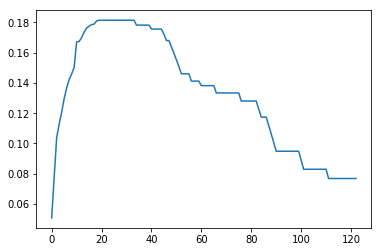

In [9]:
plt.plot(adjRs)

**Create plot of probabilities associated with the F statistic**

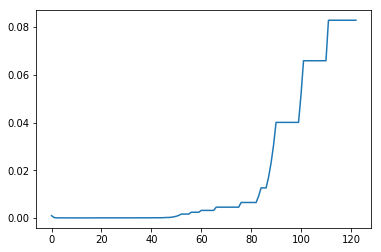

In [10]:
plt.plot(f_pvalues)

**Print adjusted R and F stat probabilities in order**

In [17]:


for c in dictionary:
    #print(str(dictionary.keys().index(c))+"{country}: {capital}".format(country=c, capital=dictionary[c])+"\n")
        print(str(list(dictionary.keys()).index(c))+ " {key} \n Adjusted R: {adjR}  Fstat(prob): {f_pvalue}".format(key=c, adjR=dictionary[c][0], f_pvalue = dictionary[c][1])+"\n")
        OLS = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + c, test_train_df[train_yrs_tt]).fit()



0 KGJT_d500_400_height_m 
 Adjusted R: 0.05075146121783536  Fstat(prob): 0.0009528194614471743

1 KGJT_d500_200_tmpc+ KGJT_d500_400_height_m 
 Adjusted R: 0.07743707360594765  Fstat(prob): 0.0001748216450403446

2 KGJT_d250_200_dwpc+ KGJT_d500_200_tmpc+ KGJT_d500_400_height_m 
 Adjusted R: 0.10377261724587628  Fstat(prob): 2.823218968971072e-05

3 KGJT_700mb_speed_kts+ KGJT_d250_200_dwpc+ KGJT_d500_200_tmpc+ KGJT_d500_400_height_m 
 Adjusted R: 0.11274193997030113  Fstat(prob): 2.411128649763281e-05

4 KGJT_250mb_tmpc+ KGJT_700mb_speed_kts+ KGJT_d250_200_dwpc+ KGJT_d500_200_tmpc+ KGJT_d500_400_height_m 
 Adjusted R: 0.1205059920683127  Fstat(prob): 2.1422773866242445e-05

5 KGJT_d300_250_drct+ KGJT_250mb_tmpc+ KGJT_700mb_speed_kts+ KGJT_d250_200_dwpc+ KGJT_d500_200_tmpc+ KGJT_d500_400_height_m 
 Adjusted R: 0.1296139584725613  Fstat(prob): 1.5887124950365422e-05

6 KGJT_d700_500_drct+ KGJT_d300_250_drct+ KGJT_250mb_tmpc+ KGJT_700mb_speed_kts+ KGJT_d250_200_dwpc+ KGJT_d500_200_tmpc+ KGJ

26 KGJT_d500_250_tmpc+ KGJT_d500_300_drct+ KGJT_500mb_tmpc+ KGJT_d500_250_drct+ KGJT_d700_500_tmpc+ KGJT_d700_250_tmpc+ KGJT_d500_200_speed_kts+ KGJT_d700_300_drct+ KGJT_500mb_height_m+ LXV_Pressure_hp+ KGJT_500mb_dwpc+ KGJT_200mb_tmpc+ KGJT_d250_200_speed_kts+ KGJT_700mb_tmpc+ CMtn_WindDirection_deg+ KGJT_d700_400_height_m+ LXV_Dewpoint_degC+ CMtn_Dewpoint_degC+ KGJT_d500_250_speed_kts+ KGJT_d500_300_dwpc+ KGJT_d700_500_drct+ KGJT_d300_250_drct+ KGJT_250mb_tmpc+ KGJT_700mb_speed_kts+ KGJT_d250_200_dwpc+ KGJT_d500_200_tmpc+ KGJT_d500_400_height_m 
 Adjusted R: 0.18142517612504372  Fstat(prob): 2.8626209462326827e-05

27 KGJT_d700_250_drct+ KGJT_d500_250_tmpc+ KGJT_d500_300_drct+ KGJT_500mb_tmpc+ KGJT_d500_250_drct+ KGJT_d700_500_tmpc+ KGJT_d700_250_tmpc+ KGJT_d500_200_speed_kts+ KGJT_d700_300_drct+ KGJT_500mb_height_m+ LXV_Pressure_hp+ KGJT_500mb_dwpc+ KGJT_200mb_tmpc+ KGJT_d250_200_speed_kts+ KGJT_700mb_tmpc+ CMtn_WindDirection_deg+ KGJT_d700_400_height_m+ LXV_Dewpoint_degC+ CMtn_Dewp

38 KGJT_200mb_speed_kts+ KGJT_d700_200_speed_kts+ KGJT_500mb_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_300mb_dwpc+ KGJT_d250_200_tmpc+ KGJT_d700_200_tmpc+ KGJT_d700_500_height_m+ KGJT_400mb_height_m+ KGJT_700mb_height_m+ KGJT_d700_250_drct+ KGJT_d500_250_tmpc+ KGJT_d500_300_drct+ KGJT_500mb_tmpc+ KGJT_d500_250_drct+ KGJT_d700_500_tmpc+ KGJT_d700_250_tmpc+ KGJT_d500_200_speed_kts+ KGJT_d700_300_drct+ KGJT_500mb_height_m+ LXV_Pressure_hp+ KGJT_500mb_dwpc+ KGJT_200mb_tmpc+ KGJT_d250_200_speed_kts+ KGJT_700mb_tmpc+ CMtn_WindDirection_deg+ KGJT_d700_400_height_m+ LXV_Dewpoint_degC+ CMtn_Dewpoint_degC+ KGJT_d500_250_speed_kts+ KGJT_d500_300_dwpc+ KGJT_d700_500_drct+ KGJT_d300_250_drct+ KGJT_250mb_tmpc+ KGJT_700mb_speed_kts+ KGJT_d250_200_dwpc+ KGJT_d500_200_tmpc+ KGJT_d500_400_height_m 
 Adjusted R: 0.17820474123982866  Fstat(prob): 4.677010100312215e-05

39 KGJT_250mb_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d700_200_speed_kts+ KGJT_500mb_speed_kts+ KGJT_d700_250_speed_


47 KGJT_d400_250_dwpc+ KGJT_d400_200_dwpc+ KGJT_d250_200_height_m+ KGJT_d400_250_tmpc+ KGJT_d400_200_tmpc+ KGJT_d700_400_tmpc+ KGJT_400mb_tmpc+ KGJT_d500_400_tmpc+ KGJT_250mb_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d700_200_speed_kts+ KGJT_500mb_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_300mb_dwpc+ KGJT_d250_200_tmpc+ KGJT_d700_200_tmpc+ KGJT_d700_500_height_m+ KGJT_400mb_height_m+ KGJT_700mb_height_m+ KGJT_d700_250_drct+ KGJT_d500_250_tmpc+ KGJT_d500_300_drct+ KGJT_500mb_tmpc+ KGJT_d500_250_drct+ KGJT_d700_500_tmpc+ KGJT_d700_250_tmpc+ KGJT_d500_200_speed_kts+ KGJT_d700_300_drct+ KGJT_500mb_height_m+ LXV_Pressure_hp+ KGJT_500mb_dwpc+ KGJT_200mb_tmpc+ KGJT_d250_200_speed_kts+ KGJT_700mb_tmpc+ CMtn_WindDirection_deg+ KGJT_d700_400_height_m+ LXV_Dewpoint_degC+ CMtn_Dewpoint_degC+ KGJT_d500_250_speed_kts+ KGJT_d500_300_dwpc+ KGJT_d700_500_drct+ KGJT_d300_250_drct+ KGJT_250mb_tmpc+ KGJT_700mb_speed_kts+ KGJT_d250_200_dwpc+ KGJT_d500_200_tmpc+ KGJT_d500_400_height_m 


56 KGJT_300mb_height_m+ KGJT_d500_400_drct+ KGJT_d400_250_drct+ KGJT_d700_400_drct+ KGJT_d400_300_drct+ LXV_WindSpeed_mps+ KGJT_200mb_drct+ LXV_12hr_delta_Pressure_hp+ KGJT_d400_300_speed_kts+ KGJT_d400_250_dwpc+ KGJT_d400_200_dwpc+ KGJT_d250_200_height_m+ KGJT_d400_250_tmpc+ KGJT_d400_200_tmpc+ KGJT_d700_400_tmpc+ KGJT_400mb_tmpc+ KGJT_d500_400_tmpc+ KGJT_250mb_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d700_200_speed_kts+ KGJT_500mb_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_300mb_dwpc+ KGJT_d250_200_tmpc+ KGJT_d700_200_tmpc+ KGJT_d700_500_height_m+ KGJT_400mb_height_m+ KGJT_700mb_height_m+ KGJT_d700_250_drct+ KGJT_d500_250_tmpc+ KGJT_d500_300_drct+ KGJT_500mb_tmpc+ KGJT_d500_250_drct+ KGJT_d700_500_tmpc+ KGJT_d700_250_tmpc+ KGJT_d500_200_speed_kts+ KGJT_d700_300_drct+ KGJT_500mb_height_m+ LXV_Pressure_hp+ KGJT_500mb_dwpc+ KGJT_200mb_tmpc+ KGJT_d250_200_speed_kts+ KGJT_700mb_tmpc+ CMtn_WindDirection_deg+ KGJT_d700_400_height_m+ LXV_Dewpoint_degC+ CMtn_Dewpoint_degC+

64 KGJT_d400_300_tmpc+ KGJT_d700_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d500_300_tmpc+ KGJT_d300_250_tmpc+ KGJT_d400_300_height_m+ KGJT_d500_300_height_m+ KGJT_d700_300_height_m+ KGJT_300mb_height_m+ KGJT_d500_400_drct+ KGJT_d400_250_drct+ KGJT_d700_400_drct+ KGJT_d400_300_drct+ LXV_WindSpeed_mps+ KGJT_200mb_drct+ LXV_12hr_delta_Pressure_hp+ KGJT_d400_300_speed_kts+ KGJT_d400_250_dwpc+ KGJT_d400_200_dwpc+ KGJT_d250_200_height_m+ KGJT_d400_250_tmpc+ KGJT_d400_200_tmpc+ KGJT_d700_400_tmpc+ KGJT_400mb_tmpc+ KGJT_d500_400_tmpc+ KGJT_250mb_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d700_200_speed_kts+ KGJT_500mb_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_300mb_dwpc+ KGJT_d250_200_tmpc+ KGJT_d700_200_tmpc+ KGJT_d700_500_height_m+ KGJT_400mb_height_m+ KGJT_700mb_height_m+ KGJT_d700_250_drct+ KGJT_d500_250_tmpc+ KGJT_d500_300_drct+ KGJT_500mb_tmpc+ KGJT_d500_250_drct+ KGJT_d700_500_tmpc+ KGJT_d700_250_tmpc+ KGJT_d500_200_speed_kts+ KGJT_d700_300_drct+ KGJT_500mb_height_m+ LXV_Pressu

70 KGJT_250mb_height_m+ KGJT_d700_250_height_m+ KGJT_d300_200_height_m+ KGJT_d300_250_height_m+ KGJT_200mb_height_m+ KGJT_d300_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_d700_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d500_300_tmpc+ KGJT_d300_250_tmpc+ KGJT_d400_300_height_m+ KGJT_d500_300_height_m+ KGJT_d700_300_height_m+ KGJT_300mb_height_m+ KGJT_d500_400_drct+ KGJT_d400_250_drct+ KGJT_d700_400_drct+ KGJT_d400_300_drct+ LXV_WindSpeed_mps+ KGJT_200mb_drct+ LXV_12hr_delta_Pressure_hp+ KGJT_d400_300_speed_kts+ KGJT_d400_250_dwpc+ KGJT_d400_200_dwpc+ KGJT_d250_200_height_m+ KGJT_d400_250_tmpc+ KGJT_d400_200_tmpc+ KGJT_d700_400_tmpc+ KGJT_400mb_tmpc+ KGJT_d500_400_tmpc+ KGJT_250mb_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d700_200_speed_kts+ KGJT_500mb_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_300mb_dwpc+ KGJT_d250_200_tmpc+ KGJT_d700_200_tmpc+ KGJT_d700_500_height_m+ KGJT_400mb_height_m+ KGJT_700mb_height_m+ KGJT_d700_250_drct+ KGJT_d500_250_tmpc+ KGJT_d500_300_drct+ KGJT_500mb_tmpc+ KG

76 KGJT_d850_300_height_m+ KGJT_d500_200_height_m+ KGJT_d400_250_height_m+ KGJT_d700_200_height_m+ KGJT_d500_250_height_m+ KGJT_d400_200_height_m+ KGJT_250mb_height_m+ KGJT_d700_250_height_m+ KGJT_d300_200_height_m+ KGJT_d300_250_height_m+ KGJT_200mb_height_m+ KGJT_d300_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_d700_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d500_300_tmpc+ KGJT_d300_250_tmpc+ KGJT_d400_300_height_m+ KGJT_d500_300_height_m+ KGJT_d700_300_height_m+ KGJT_300mb_height_m+ KGJT_d500_400_drct+ KGJT_d400_250_drct+ KGJT_d700_400_drct+ KGJT_d400_300_drct+ LXV_WindSpeed_mps+ KGJT_200mb_drct+ LXV_12hr_delta_Pressure_hp+ KGJT_d400_300_speed_kts+ KGJT_d400_250_dwpc+ KGJT_d400_200_dwpc+ KGJT_d250_200_height_m+ KGJT_d400_250_tmpc+ KGJT_d400_200_tmpc+ KGJT_d700_400_tmpc+ KGJT_400mb_tmpc+ KGJT_d500_400_tmpc+ KGJT_250mb_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d700_200_speed_kts+ KGJT_500mb_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_300mb_dwpc+ KGJT_d250_200_tmpc+ KGJT_d700_200_tmpc+ K

82 KGJT_d850_250_height_m+ KGJT_d850_200_height_m+ KGJT_d850_500_height_m+ KGJT_850mb_height_m+ KGJT_d850_700_height_m+ KGJT_d850_400_height_m+ KGJT_d850_300_height_m+ KGJT_d500_200_height_m+ KGJT_d400_250_height_m+ KGJT_d700_200_height_m+ KGJT_d500_250_height_m+ KGJT_d400_200_height_m+ KGJT_250mb_height_m+ KGJT_d700_250_height_m+ KGJT_d300_200_height_m+ KGJT_d300_250_height_m+ KGJT_200mb_height_m+ KGJT_d300_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_d700_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d500_300_tmpc+ KGJT_d300_250_tmpc+ KGJT_d400_300_height_m+ KGJT_d500_300_height_m+ KGJT_d700_300_height_m+ KGJT_300mb_height_m+ KGJT_d500_400_drct+ KGJT_d400_250_drct+ KGJT_d700_400_drct+ KGJT_d400_300_drct+ LXV_WindSpeed_mps+ KGJT_200mb_drct+ LXV_12hr_delta_Pressure_hp+ KGJT_d400_300_speed_kts+ KGJT_d400_250_dwpc+ KGJT_d400_200_dwpc+ KGJT_d250_200_height_m+ KGJT_d400_250_tmpc+ KGJT_d400_200_tmpc+ KGJT_d700_400_tmpc+ KGJT_400mb_tmpc+ KGJT_d500_400_tmpc+ KGJT_250mb_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d700_200_


87 LXV_Temperature_degC+ KGJT_700mb_dwpc+ KGJT_d700_300_dwpc+ KGJT_d700_500_dwpc+ CMtnSNTL_Temp_degC+ KGJT_d850_250_height_m+ KGJT_d850_200_height_m+ KGJT_d850_500_height_m+ KGJT_850mb_height_m+ KGJT_d850_700_height_m+ KGJT_d850_400_height_m+ KGJT_d850_300_height_m+ KGJT_d500_200_height_m+ KGJT_d400_250_height_m+ KGJT_d700_200_height_m+ KGJT_d500_250_height_m+ KGJT_d400_200_height_m+ KGJT_250mb_height_m+ KGJT_d700_250_height_m+ KGJT_d300_200_height_m+ KGJT_d300_250_height_m+ KGJT_200mb_height_m+ KGJT_d300_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_d700_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d500_300_tmpc+ KGJT_d300_250_tmpc+ KGJT_d400_300_height_m+ KGJT_d500_300_height_m+ KGJT_d700_300_height_m+ KGJT_300mb_height_m+ KGJT_d500_400_drct+ KGJT_d400_250_drct+ KGJT_d700_400_drct+ KGJT_d400_300_drct+ LXV_WindSpeed_mps+ KGJT_200mb_drct+ LXV_12hr_delta_Pressure_hp+ KGJT_d400_300_speed_kts+ KGJT_d400_250_dwpc+ KGJT_d400_200_dwpc+ KGJT_d250_200_height_m+ KGJT_d400_250_tmpc+ KGJT_d400_200_tmpc+ KGJT_d700_400_t


93 KGJT_d400_200_drct+ KGJT_300mb_drct+ KGJT_d300_200_drct+ KGJT_400mb_drct+ CMtn_Temperature_degC+ LXV_WindDirection_deg+ LXV_Temperature_degC+ KGJT_700mb_dwpc+ KGJT_d700_300_dwpc+ KGJT_d700_500_dwpc+ CMtnSNTL_Temp_degC+ KGJT_d850_250_height_m+ KGJT_d850_200_height_m+ KGJT_d850_500_height_m+ KGJT_850mb_height_m+ KGJT_d850_700_height_m+ KGJT_d850_400_height_m+ KGJT_d850_300_height_m+ KGJT_d500_200_height_m+ KGJT_d400_250_height_m+ KGJT_d700_200_height_m+ KGJT_d500_250_height_m+ KGJT_d400_200_height_m+ KGJT_250mb_height_m+ KGJT_d700_250_height_m+ KGJT_d300_200_height_m+ KGJT_d300_250_height_m+ KGJT_200mb_height_m+ KGJT_d300_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_d700_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d500_300_tmpc+ KGJT_d300_250_tmpc+ KGJT_d400_300_height_m+ KGJT_d500_300_height_m+ KGJT_d700_300_height_m+ KGJT_300mb_height_m+ KGJT_d500_400_drct+ KGJT_d400_250_drct+ KGJT_d700_400_drct+ KGJT_d400_300_drct+ LXV_WindSpeed_mps+ KGJT_200mb_drct+ LXV_12hr_delta_Pressure_hp+ KGJT_d400_300_speed_kts+


97 KGJT_500mb_drct+ KGJT_d250_200_drct+ KGJT_250mb_drct+ KGJT_d700_200_drct+ KGJT_d400_200_drct+ KGJT_300mb_drct+ KGJT_d300_200_drct+ KGJT_400mb_drct+ CMtn_Temperature_degC+ LXV_WindDirection_deg+ LXV_Temperature_degC+ KGJT_700mb_dwpc+ KGJT_d700_300_dwpc+ KGJT_d700_500_dwpc+ CMtnSNTL_Temp_degC+ KGJT_d850_250_height_m+ KGJT_d850_200_height_m+ KGJT_d850_500_height_m+ KGJT_850mb_height_m+ KGJT_d850_700_height_m+ KGJT_d850_400_height_m+ KGJT_d850_300_height_m+ KGJT_d500_200_height_m+ KGJT_d400_250_height_m+ KGJT_d700_200_height_m+ KGJT_d500_250_height_m+ KGJT_d400_200_height_m+ KGJT_250mb_height_m+ KGJT_d700_250_height_m+ KGJT_d300_200_height_m+ KGJT_d300_250_height_m+ KGJT_200mb_height_m+ KGJT_d300_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_d700_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d500_300_tmpc+ KGJT_d300_250_tmpc+ KGJT_d400_300_height_m+ KGJT_d500_300_height_m+ KGJT_d700_300_height_m+ KGJT_300mb_height_m+ KGJT_d500_400_drct+ KGJT_d400_250_drct+ KGJT_d700_400_drct+ KGJT_d400_300_drct+ LXV_WindSpeed_

101 KGJT_d400_200_speed_kts+ CMtn_WindSpeed_mps+ KGJT_d500_200_drct+ KGJT_700mb_drct+ KGJT_500mb_drct+ KGJT_d250_200_drct+ KGJT_250mb_drct+ KGJT_d700_200_drct+ KGJT_d400_200_drct+ KGJT_300mb_drct+ KGJT_d300_200_drct+ KGJT_400mb_drct+ CMtn_Temperature_degC+ LXV_WindDirection_deg+ LXV_Temperature_degC+ KGJT_700mb_dwpc+ KGJT_d700_300_dwpc+ KGJT_d700_500_dwpc+ CMtnSNTL_Temp_degC+ KGJT_d850_250_height_m+ KGJT_d850_200_height_m+ KGJT_d850_500_height_m+ KGJT_850mb_height_m+ KGJT_d850_700_height_m+ KGJT_d850_400_height_m+ KGJT_d850_300_height_m+ KGJT_d500_200_height_m+ KGJT_d400_250_height_m+ KGJT_d700_200_height_m+ KGJT_d500_250_height_m+ KGJT_d400_200_height_m+ KGJT_250mb_height_m+ KGJT_d700_250_height_m+ KGJT_d300_200_height_m+ KGJT_d300_250_height_m+ KGJT_200mb_height_m+ KGJT_d300_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_d700_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d500_300_tmpc+ KGJT_d300_250_tmpc+ KGJT_d400_300_height_m+ KGJT_d500_300_height_m+ KGJT_d700_300_height_m+ KGJT_300mb_height_m+ KGJT_d500_40

105 KGJT_d300_250_speed_kts+ KGJT_d500_300_speed_kts+ KGJT_d500_400_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_d400_200_speed_kts+ CMtn_WindSpeed_mps+ KGJT_d500_200_drct+ KGJT_700mb_drct+ KGJT_500mb_drct+ KGJT_d250_200_drct+ KGJT_250mb_drct+ KGJT_d700_200_drct+ KGJT_d400_200_drct+ KGJT_300mb_drct+ KGJT_d300_200_drct+ KGJT_400mb_drct+ CMtn_Temperature_degC+ LXV_WindDirection_deg+ LXV_Temperature_degC+ KGJT_700mb_dwpc+ KGJT_d700_300_dwpc+ KGJT_d700_500_dwpc+ CMtnSNTL_Temp_degC+ KGJT_d850_250_height_m+ KGJT_d850_200_height_m+ KGJT_d850_500_height_m+ KGJT_850mb_height_m+ KGJT_d850_700_height_m+ KGJT_d850_400_height_m+ KGJT_d850_300_height_m+ KGJT_d500_200_height_m+ KGJT_d400_250_height_m+ KGJT_d700_200_height_m+ KGJT_d500_250_height_m+ KGJT_d400_200_height_m+ KGJT_250mb_height_m+ KGJT_d700_250_height_m+ KGJT_d300_200_height_m+ KGJT_d300_250_height_m+ KGJT_200mb_height_m+ KGJT_d300_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_d700_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d500_300_tmpc+ KGJT_d300_250_tmpc+ KGJT_

109 KGJT_300mb_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_400mb_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_d500_300_speed_kts+ KGJT_d500_400_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_d400_200_speed_kts+ CMtn_WindSpeed_mps+ KGJT_d500_200_drct+ KGJT_700mb_drct+ KGJT_500mb_drct+ KGJT_d250_200_drct+ KGJT_250mb_drct+ KGJT_d700_200_drct+ KGJT_d400_200_drct+ KGJT_300mb_drct+ KGJT_d300_200_drct+ KGJT_400mb_drct+ CMtn_Temperature_degC+ LXV_WindDirection_deg+ LXV_Temperature_degC+ KGJT_700mb_dwpc+ KGJT_d700_300_dwpc+ KGJT_d700_500_dwpc+ CMtnSNTL_Temp_degC+ KGJT_d850_250_height_m+ KGJT_d850_200_height_m+ KGJT_d850_500_height_m+ KGJT_850mb_height_m+ KGJT_d850_700_height_m+ KGJT_d850_400_height_m+ KGJT_d850_300_height_m+ KGJT_d500_200_height_m+ KGJT_d400_250_height_m+ KGJT_d700_200_height_m+ KGJT_d500_250_height_m+ KGJT_d400_200_height_m+ KGJT_250mb_height_m+ KGJT_d700_250_height_m+ KGJT_d300_200_height_m+ KGJT_d300_250_height_m+ KGJT_200mb_height_m+ KGJT_d300_200_tmpc+ KGJT_d40

113 KGJT_d500_400_dwpc+ KGJT_d300_200_dwpc+ KGJT_d300_250_dwpc+ KGJT_d300_200_speed_kts+ KGJT_300mb_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_400mb_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_d500_300_speed_kts+ KGJT_d500_400_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_d400_200_speed_kts+ CMtn_WindSpeed_mps+ KGJT_d500_200_drct+ KGJT_700mb_drct+ KGJT_500mb_drct+ KGJT_d250_200_drct+ KGJT_250mb_drct+ KGJT_d700_200_drct+ KGJT_d400_200_drct+ KGJT_300mb_drct+ KGJT_d300_200_drct+ KGJT_400mb_drct+ CMtn_Temperature_degC+ LXV_WindDirection_deg+ LXV_Temperature_degC+ KGJT_700mb_dwpc+ KGJT_d700_300_dwpc+ KGJT_d700_500_dwpc+ CMtnSNTL_Temp_degC+ KGJT_d850_250_height_m+ KGJT_d850_200_height_m+ KGJT_d850_500_height_m+ KGJT_850mb_height_m+ KGJT_d850_700_height_m+ KGJT_d850_400_height_m+ KGJT_d850_300_height_m+ KGJT_d500_200_height_m+ KGJT_d400_250_height_m+ KGJT_d700_200_height_m+ KGJT_d500_250_height_m+ KGJT_d400_200_height_m+ KGJT_250mb_height_m+ KGJT_d700_250_height_m+ KGJT_d300_20

117 KGJT_d500_200_dwpc+ KGJT_d700_400_dwpc+ KGJT_400mb_dwpc+ KGJT_d500_250_dwpc+ KGJT_d500_400_dwpc+ KGJT_d300_200_dwpc+ KGJT_d300_250_dwpc+ KGJT_d300_200_speed_kts+ KGJT_300mb_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_400mb_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_d500_300_speed_kts+ KGJT_d500_400_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_d400_200_speed_kts+ CMtn_WindSpeed_mps+ KGJT_d500_200_drct+ KGJT_700mb_drct+ KGJT_500mb_drct+ KGJT_d250_200_drct+ KGJT_250mb_drct+ KGJT_d700_200_drct+ KGJT_d400_200_drct+ KGJT_300mb_drct+ KGJT_d300_200_drct+ KGJT_400mb_drct+ CMtn_Temperature_degC+ LXV_WindDirection_deg+ LXV_Temperature_degC+ KGJT_700mb_dwpc+ KGJT_d700_300_dwpc+ KGJT_d700_500_dwpc+ CMtnSNTL_Temp_degC+ KGJT_d850_250_height_m+ KGJT_d850_200_height_m+ KGJT_d850_500_height_m+ KGJT_850mb_height_m+ KGJT_d850_700_height_m+ KGJT_d850_400_height_m+ KGJT_d850_300_height_m+ KGJT_d500_200_height_m+ KGJT_d400_250_height_m+ KGJT_d700_200_height_m+ KGJT_d500_250_height_m+ KGJT

121 KGJT_d700_250_dwpc+ KGJT_250mb_dwpc+ KGJT_d700_200_dwpc+ KGJT_200mb_dwpc+ KGJT_d500_200_dwpc+ KGJT_d700_400_dwpc+ KGJT_400mb_dwpc+ KGJT_d500_250_dwpc+ KGJT_d500_400_dwpc+ KGJT_d300_200_dwpc+ KGJT_d300_250_dwpc+ KGJT_d300_200_speed_kts+ KGJT_300mb_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_400mb_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_d500_300_speed_kts+ KGJT_d500_400_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_d400_200_speed_kts+ CMtn_WindSpeed_mps+ KGJT_d500_200_drct+ KGJT_700mb_drct+ KGJT_500mb_drct+ KGJT_d250_200_drct+ KGJT_250mb_drct+ KGJT_d700_200_drct+ KGJT_d400_200_drct+ KGJT_300mb_drct+ KGJT_d300_200_drct+ KGJT_400mb_drct+ CMtn_Temperature_degC+ LXV_WindDirection_deg+ LXV_Temperature_degC+ KGJT_700mb_dwpc+ KGJT_d700_300_dwpc+ KGJT_d700_500_dwpc+ CMtnSNTL_Temp_degC+ KGJT_d850_250_height_m+ KGJT_d850_200_height_m+ KGJT_d850_500_height_m+ KGJT_850mb_height_m+ KGJT_d850_700_height_m+ KGJT_d850_400_height_m+ KGJT_d850_300_height_m+ KGJT_d500_200_height_m+ KG

**Find max adj R and obtain OLS summary**

In [12]:
 # Just use 'min' instead of 'max' for minimum.
print("Print maximum:")
maximum = max(dictionary, key=dictionary.get) 
print(maximum)

Print maximum:
KGJT_d500_200_speed_kts+ KGJT_d700_300_drct+ KGJT_500mb_height_m+ LXV_Pressure_hp+ KGJT_500mb_dwpc+ KGJT_200mb_tmpc+ KGJT_d250_200_speed_kts+ KGJT_700mb_tmpc+ CMtn_WindDirection_deg+ KGJT_d700_400_height_m+ LXV_Dewpoint_degC+ CMtn_Dewpoint_degC+ KGJT_d500_250_speed_kts+ KGJT_d500_300_dwpc+ KGJT_d700_500_drct+ KGJT_d300_250_drct+ KGJT_250mb_tmpc+ KGJT_700mb_speed_kts+ KGJT_d250_200_dwpc+ KGJT_d500_200_tmpc+ KGJT_d500_400_height_m


In [13]:
maximum_all_str = max(dictionary, key=dictionary.get) 
print(maximum_all_str)

maxOLS_all = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + maximum_all_str , test_train_df[train_yrs_tt]).fit() 
print(maxOLS_all.summary())


KGJT_d500_200_speed_kts+ KGJT_d700_300_drct+ KGJT_500mb_height_m+ LXV_Pressure_hp+ KGJT_500mb_dwpc+ KGJT_200mb_tmpc+ KGJT_d250_200_speed_kts+ KGJT_700mb_tmpc+ CMtn_WindDirection_deg+ KGJT_d700_400_height_m+ LXV_Dewpoint_degC+ CMtn_Dewpoint_degC+ KGJT_d500_250_speed_kts+ KGJT_d500_300_dwpc+ KGJT_d700_500_drct+ KGJT_d300_250_drct+ KGJT_250mb_tmpc+ KGJT_700mb_speed_kts+ KGJT_d250_200_dwpc+ KGJT_d500_200_tmpc+ KGJT_d500_400_height_m
                                      OLS Regression Results                                     
Dep. Variable:     CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in   R-squared:                       0.267
Model:                                               OLS   Adj. R-squared:                  0.181
Method:                                    Least Squares   F-statistic:                     3.128
Date:                                   Sat, 18 May 2019   Prob (F-statistic):           2.86e-05
Time:                                           00:39:37   Log-Likelihood:   

**Print QQ plot**

**There are a few variables with P|t| values which are high, indicative of high randomness. Let's test different P|t| thresholds for which to remove variables, rerun and model for each set of variables, and see what threshold might glean best results**

In [14]:
rsq_adj = 0
thresh = 0

goodp_str = ""
highp_var = []

maximum_all_str = max(dictionary, key=dictionary.get)    #this is the string of variables found in previous OLS run associated with mad adjusted R squared.
print(maximum_all_str)


for test_thresh in range(1, 100):   #loop through different P|t| thresholds ranging from 1 to 100.  Note floats are not allowed here 
  print(test_thresh)
  highp_var = [var for var in maxOLS_all.pvalues.keys() if maxOLS_all.pvalues[var]>=test_thresh*0.01]  #check P|t| for each variable against threshold and store in list
  
  testgoodp_str = maximum_all_str   #reset testgoodp_str 
    
  for var in highp_var:
    testgoodp_str = testgoodp_str.replace("+ " + var, "")   #  
     

 

  maxOLS_testgoodp = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + testgoodp_str,test_train_df[train_yrs_tt]).fit()
  print(testgoodp_str, maxOLS_testgoodp.rsquared_adj, test_thresh*0.01)
  #print(maxOLS_testgoodp.rsquared_adj)
  if maxOLS_testgoodp.rsquared_adj > rsq_adj:
      rsq_adj = maxOLS_testgoodp.rsquared_adj
      print(maxOLS_testgoodp.rsquared_adj, test_thresh*0.01)
      goodp_str = testgoodp_str
      thresh = test_thresh*0.01

    
print("\n best threshold is:" + str(thresh))
maxOLS_goodp = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + goodp_str,test_train_df[train_yrs_tt]).fit() 
print(maxOLS_goodp.summary())


KGJT_d500_200_speed_kts+ KGJT_d700_300_drct+ KGJT_500mb_height_m+ LXV_Pressure_hp+ KGJT_500mb_dwpc+ KGJT_200mb_tmpc+ KGJT_d250_200_speed_kts+ KGJT_700mb_tmpc+ CMtn_WindDirection_deg+ KGJT_d700_400_height_m+ LXV_Dewpoint_degC+ CMtn_Dewpoint_degC+ KGJT_d500_250_speed_kts+ KGJT_d500_300_dwpc+ KGJT_d700_500_drct+ KGJT_d300_250_drct+ KGJT_250mb_tmpc+ KGJT_700mb_speed_kts+ KGJT_d250_200_dwpc+ KGJT_d500_200_tmpc+ KGJT_d500_400_height_m
1
KGJT_d500_200_speed_kts+ KGJT_d300_250_drct 0.007419774503329646 0.01
0.007419774503329646 0.01
2
KGJT_d500_200_speed_kts+ KGJT_700mb_tmpc+ CMtn_Dewpoint_degC+ KGJT_d300_250_drct 0.026612251158255606 0.02
0.026612251158255606 0.02
3
KGJT_d500_200_speed_kts+ KGJT_700mb_tmpc+ CMtn_Dewpoint_degC+ KGJT_d300_250_drct 0.026612251158255606 0.03
4
KGJT_d500_200_speed_kts+ KGJT_700mb_tmpc+ LXV_Dewpoint_degC+ CMtn_Dewpoint_degC+ KGJT_d700_500_drct+ KGJT_d300_250_drct+ KGJT_700mb_speed_kts 0.06337080995538513 0.04
0.06337080995538513 0.04
5
KGJT_d500_200_speed_kts+ KGJT

KGJT_d500_200_speed_kts+ KGJT_d700_300_drct+ KGJT_500mb_height_m+ LXV_Pressure_hp+ KGJT_500mb_dwpc+ KGJT_200mb_tmpc+ KGJT_d250_200_speed_kts+ KGJT_700mb_tmpc+ CMtn_WindDirection_deg+ KGJT_d700_400_height_m+ LXV_Dewpoint_degC+ CMtn_Dewpoint_degC+ KGJT_d500_250_speed_kts+ KGJT_d700_500_drct+ KGJT_d300_250_drct+ KGJT_250mb_tmpc+ KGJT_700mb_speed_kts+ KGJT_d250_200_dwpc+ KGJT_d500_200_tmpc 0.18944019246469923 0.3
0.18944019246469923 0.3
31
KGJT_d500_200_speed_kts+ KGJT_d700_300_drct+ KGJT_500mb_height_m+ LXV_Pressure_hp+ KGJT_500mb_dwpc+ KGJT_200mb_tmpc+ KGJT_d250_200_speed_kts+ KGJT_700mb_tmpc+ CMtn_WindDirection_deg+ KGJT_d700_400_height_m+ LXV_Dewpoint_degC+ CMtn_Dewpoint_degC+ KGJT_d500_250_speed_kts+ KGJT_d700_500_drct+ KGJT_d300_250_drct+ KGJT_250mb_tmpc+ KGJT_700mb_speed_kts+ KGJT_d250_200_dwpc+ KGJT_d500_200_tmpc 0.18944019246469923 0.31
32
KGJT_d500_200_speed_kts+ KGJT_d700_300_drct+ KGJT_500mb_height_m+ LXV_Pressure_hp+ KGJT_500mb_dwpc+ KGJT_200mb_tmpc+ KGJT_d250_200_speed_kts+ K

KGJT_d500_200_speed_kts+ KGJT_d700_300_drct+ KGJT_500mb_height_m+ LXV_Pressure_hp+ KGJT_500mb_dwpc+ KGJT_200mb_tmpc+ KGJT_d250_200_speed_kts+ KGJT_700mb_tmpc+ CMtn_WindDirection_deg+ KGJT_d700_400_height_m+ LXV_Dewpoint_degC+ CMtn_Dewpoint_degC+ KGJT_d500_250_speed_kts+ KGJT_d700_500_drct+ KGJT_d300_250_drct+ KGJT_250mb_tmpc+ KGJT_700mb_speed_kts+ KGJT_d250_200_dwpc+ KGJT_d500_200_tmpc 0.18944019246469923 0.54
55
KGJT_d500_200_speed_kts+ KGJT_d700_300_drct+ KGJT_500mb_height_m+ LXV_Pressure_hp+ KGJT_500mb_dwpc+ KGJT_200mb_tmpc+ KGJT_d250_200_speed_kts+ KGJT_700mb_tmpc+ CMtn_WindDirection_deg+ KGJT_d700_400_height_m+ LXV_Dewpoint_degC+ CMtn_Dewpoint_degC+ KGJT_d500_250_speed_kts+ KGJT_d700_500_drct+ KGJT_d300_250_drct+ KGJT_250mb_tmpc+ KGJT_700mb_speed_kts+ KGJT_d250_200_dwpc+ KGJT_d500_200_tmpc 0.18944019246469923 0.55
56
KGJT_d500_200_speed_kts+ KGJT_d700_300_drct+ KGJT_500mb_height_m+ LXV_Pressure_hp+ KGJT_500mb_dwpc+ KGJT_200mb_tmpc+ KGJT_d250_200_speed_kts+ KGJT_700mb_tmpc+ CMtn_Wi

KGJT_d500_200_speed_kts+ KGJT_d700_300_drct+ KGJT_500mb_height_m+ LXV_Pressure_hp+ KGJT_500mb_dwpc+ KGJT_200mb_tmpc+ KGJT_d250_200_speed_kts+ KGJT_700mb_tmpc+ CMtn_WindDirection_deg+ KGJT_d700_400_height_m+ LXV_Dewpoint_degC+ CMtn_Dewpoint_degC+ KGJT_d500_250_speed_kts+ KGJT_d700_500_drct+ KGJT_d300_250_drct+ KGJT_250mb_tmpc+ KGJT_700mb_speed_kts+ KGJT_d250_200_dwpc+ KGJT_d500_200_tmpc+ KGJT_d500_400_height_m 0.1858441964917017 0.74
75
KGJT_d500_200_speed_kts+ KGJT_d700_300_drct+ KGJT_500mb_height_m+ LXV_Pressure_hp+ KGJT_500mb_dwpc+ KGJT_200mb_tmpc+ KGJT_d250_200_speed_kts+ KGJT_700mb_tmpc+ CMtn_WindDirection_deg+ KGJT_d700_400_height_m+ LXV_Dewpoint_degC+ CMtn_Dewpoint_degC+ KGJT_d500_250_speed_kts+ KGJT_d700_500_drct+ KGJT_d300_250_drct+ KGJT_250mb_tmpc+ KGJT_700mb_speed_kts+ KGJT_d250_200_dwpc+ KGJT_d500_200_tmpc+ KGJT_d500_400_height_m 0.1858441964917017 0.75
76
KGJT_d500_200_speed_kts+ KGJT_d700_300_drct+ KGJT_500mb_height_m+ LXV_Pressure_hp+ KGJT_500mb_dwpc+ KGJT_200mb_tmpc+ KGJ

KGJT_d500_200_speed_kts+ KGJT_d700_300_drct+ KGJT_500mb_height_m+ LXV_Pressure_hp+ KGJT_500mb_dwpc+ KGJT_200mb_tmpc+ KGJT_d250_200_speed_kts+ KGJT_700mb_tmpc+ CMtn_WindDirection_deg+ KGJT_d700_400_height_m+ LXV_Dewpoint_degC+ CMtn_Dewpoint_degC+ KGJT_d500_250_speed_kts+ KGJT_d500_300_dwpc+ KGJT_d700_500_drct+ KGJT_d300_250_drct+ KGJT_250mb_tmpc+ KGJT_700mb_speed_kts+ KGJT_d250_200_dwpc+ KGJT_d500_200_tmpc+ KGJT_d500_400_height_m 0.18142517612504594 0.92
93
KGJT_d500_200_speed_kts+ KGJT_d700_300_drct+ KGJT_500mb_height_m+ LXV_Pressure_hp+ KGJT_500mb_dwpc+ KGJT_200mb_tmpc+ KGJT_d250_200_speed_kts+ KGJT_700mb_tmpc+ CMtn_WindDirection_deg+ KGJT_d700_400_height_m+ LXV_Dewpoint_degC+ CMtn_Dewpoint_degC+ KGJT_d500_250_speed_kts+ KGJT_d500_300_dwpc+ KGJT_d700_500_drct+ KGJT_d300_250_drct+ KGJT_250mb_tmpc+ KGJT_700mb_speed_kts+ KGJT_d250_200_dwpc+ KGJT_d500_200_tmpc+ KGJT_d500_400_height_m 0.18142517612504594 0.93
94
KGJT_d500_200_speed_kts+ KGJT_d700_300_drct+ KGJT_500mb_height_m+ LXV_Pressure

In [15]:
import csv
actual_snf = test_train_df[test_yrs_tt]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][test_train_df[test_yrs_tt]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']>=3]
predict_snf = maxOLS_goodp.predict(test_train_df[test_yrs_tt][test_train_df[test_yrs_tt]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']>=3])
print(len(actual_snf))
rows = zip(actual_snf, predict_snf)

with open(r'C:\Users\RAPP\Documents\Capstone\Analysis Notebooks\model_predictions\A0-UASFC_0617Train_OLS.csv', "w") as f:
    writer = csv.writer(f)
    for row in rows:
        writer.writerow(row)

62


In [16]:
print(test_yrs_tt)

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fa